### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:0


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [6]:
train_images = glob.glob('/data/segmentation/Kvasir-SEG/trainset/images/*')
train_labels = glob.glob('/data/segmentation/Kvasir-SEG/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/Kvasir-SEG/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/Kvasir-SEG/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외


train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)


custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))


custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 600 elements
My custom valing-dataset has 200 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

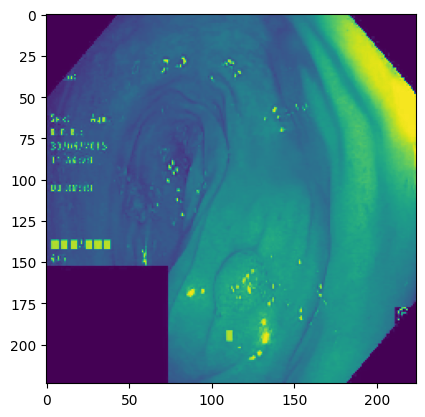

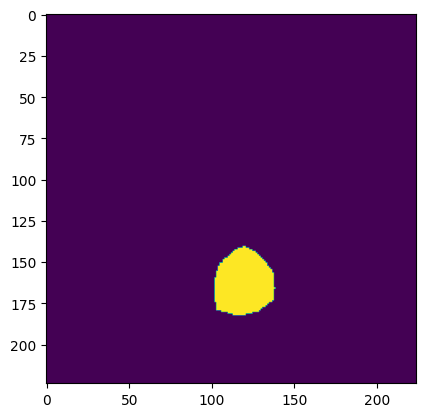

3픽셀의 평균값이라 색깔이 변경됨.


In [7]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [8]:
# Begin training
from models.model_library.models.segnet import SegResNet
model = SegResNet(num_classes = 1)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [9]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'segresnet'
data_name = 'Kvasir'

# 5. Training

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


 Epoch: 1 of 100, Iter.: 75 of 75, Train Loss: 1.335482, IoU: 0.269685, Dice: 0.390976
 Epoch: 1 of 100, Iter.: 75 of 75, Valid Loss: 1.050311, IoU: 0.397424, Dice: 0.536688

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


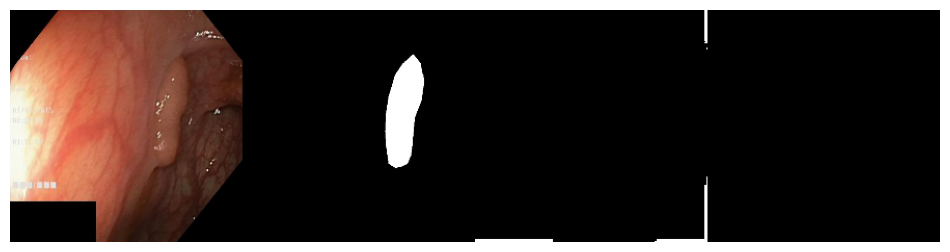

 Epoch: 2 of 100, Iter.: 75 of 75, Train Loss: 0.826661, IoU: 0.507682, Dice: 0.642102
 Epoch: 2 of 100, Iter.: 75 of 75, Valid Loss: 0.644639, IoU: 0.562214, Dice: 0.697600


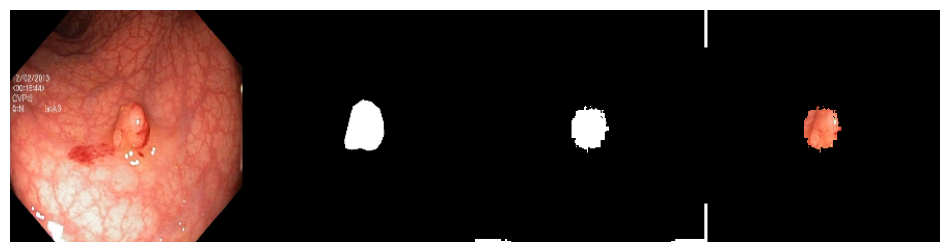

 Epoch: 3 of 100, Iter.: 75 of 75, Train Loss: 0.531519, IoU: 0.596030, Dice: 0.723128
 Epoch: 3 of 100, Iter.: 75 of 75, Valid Loss: 0.528847, IoU: 0.586168, Dice: 0.715595


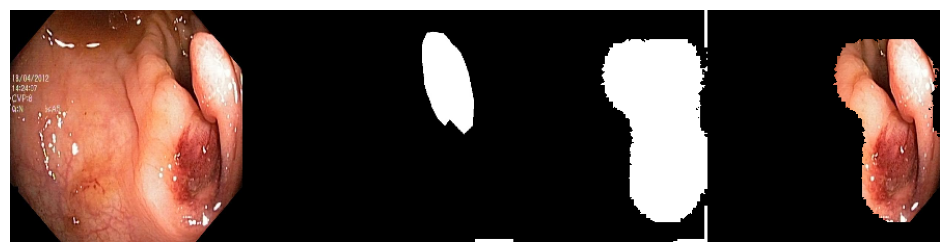

 Epoch: 4 of 100, Iter.: 75 of 75, Train Loss: 0.377755, IoU: 0.664199, Dice: 0.780462
 Epoch: 4 of 100, Iter.: 75 of 75, Valid Loss: 0.431816, IoU: 0.654280, Dice: 0.768917


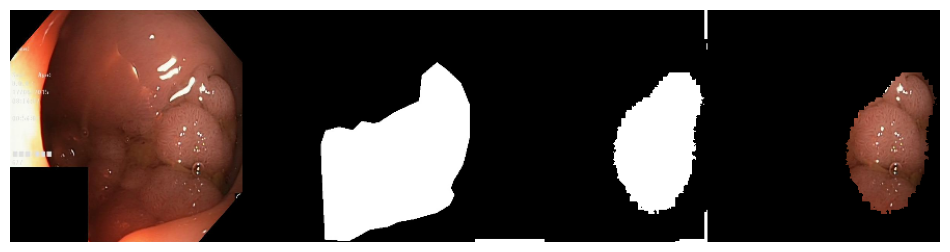

 Epoch: 5 of 100, Iter.: 75 of 75, Train Loss: 0.295469, IoU: 0.707952, Dice: 0.814528
 Epoch: 5 of 100, Iter.: 75 of 75, Valid Loss: 0.488792, IoU: 0.608433, Dice: 0.722424


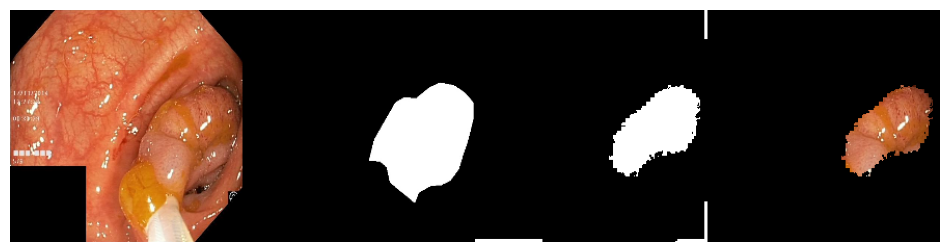

 Epoch: 6 of 100, Iter.: 75 of 75, Train Loss: 0.268258, IoU: 0.722240, Dice: 0.825338
 Epoch: 6 of 100, Iter.: 75 of 75, Valid Loss: 0.658376, IoU: 0.533156, Dice: 0.647079


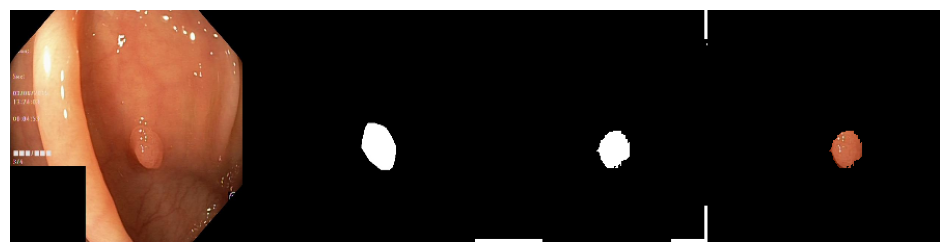

 Epoch: 7 of 100, Iter.: 75 of 75, Train Loss: 0.247514, IoU: 0.734103, Dice: 0.834177
 Epoch: 7 of 100, Iter.: 75 of 75, Valid Loss: 0.470917, IoU: 0.637915, Dice: 0.754331


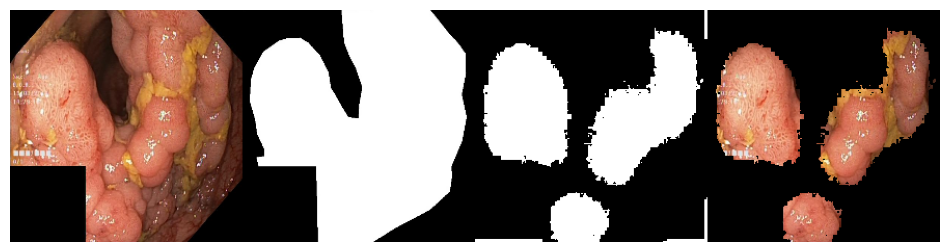

 Epoch: 8 of 100, Iter.: 75 of 75, Train Loss: 0.201286, IoU: 0.758626, Dice: 0.852106
 Epoch: 8 of 100, Iter.: 75 of 75, Valid Loss: 0.402632, IoU: 0.678206, Dice: 0.783218


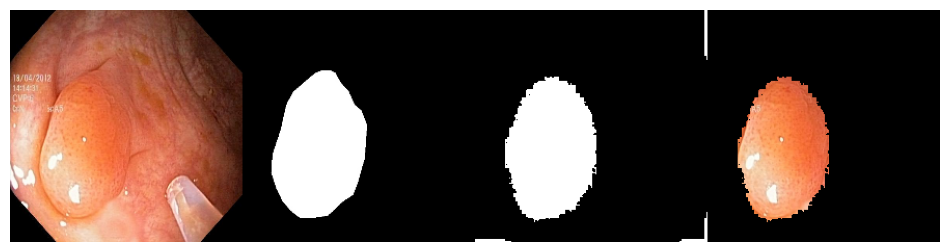

 Epoch: 9 of 100, Iter.: 75 of 75, Train Loss: 0.212741, IoU: 0.747548, Dice: 0.844494
 Epoch: 9 of 100, Iter.: 75 of 75, Valid Loss: 0.526376, IoU: 0.631153, Dice: 0.740760


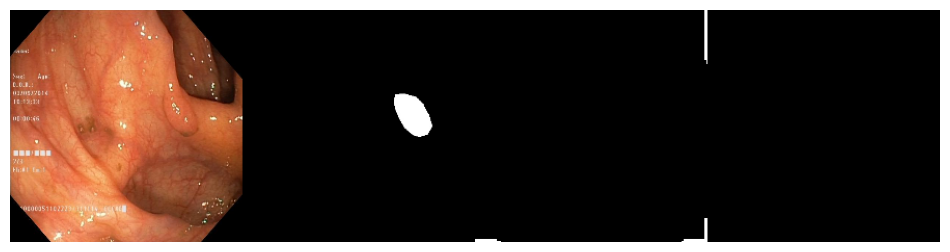

 Epoch: 10 of 100, Iter.: 75 of 75, Train Loss: 0.194508, IoU: 0.761942, Dice: 0.855139
 Epoch: 10 of 100, Iter.: 75 of 75, Valid Loss: 0.405400, IoU: 0.670989, Dice: 0.776090


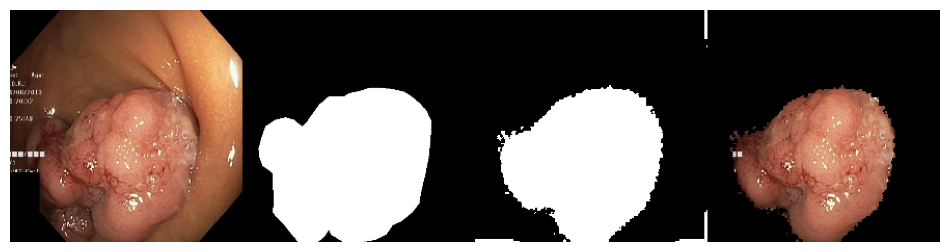

 Epoch: 11 of 100, Iter.: 75 of 75, Train Loss: 0.143171, IoU: 0.794743, Dice: 0.877924
 Epoch: 11 of 100, Iter.: 75 of 75, Valid Loss: 0.511914, IoU: 0.625703, Dice: 0.737901


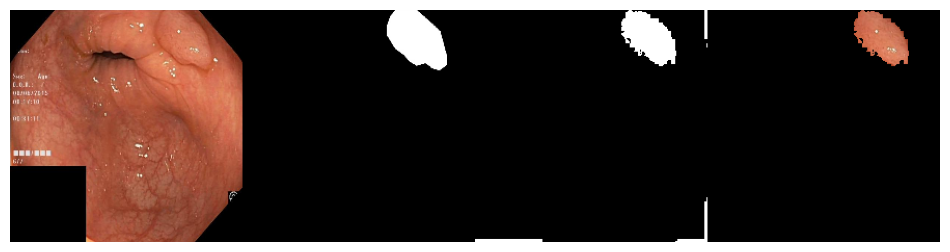

 Epoch: 12 of 100, Iter.: 75 of 75, Train Loss: 0.191250, IoU: 0.771335, Dice: 0.860645
 Epoch: 12 of 100, Iter.: 75 of 75, Valid Loss: 0.447403, IoU: 0.665166, Dice: 0.773091


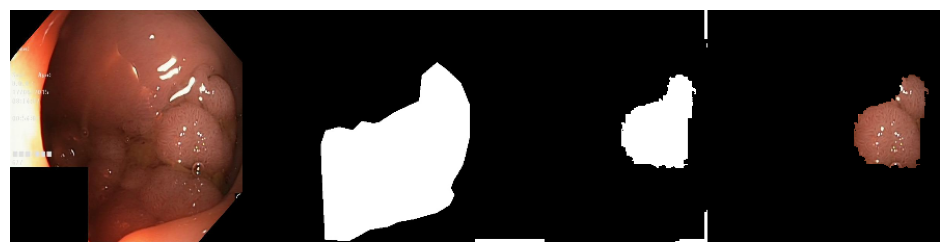

 Epoch: 13 of 100, Iter.: 75 of 75, Train Loss: 0.135026, IoU: 0.804859, Dice: 0.884592
 Epoch: 13 of 100, Iter.: 75 of 75, Valid Loss: 0.434038, IoU: 0.743276, Dice: 0.828914


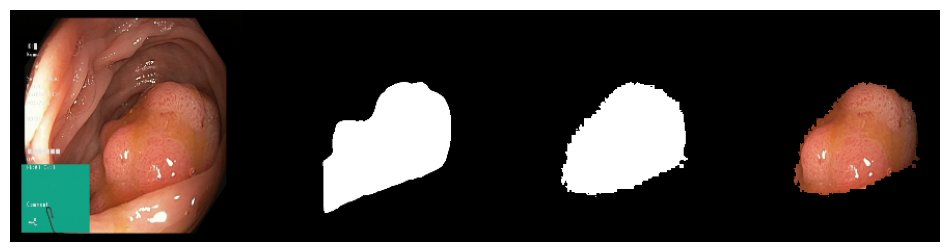

 Epoch: 14 of 100, Iter.: 75 of 75, Train Loss: 0.109483, IoU: 0.898465, Dice: 0.942054
 Epoch: 14 of 100, Iter.: 75 of 75, Valid Loss: 0.434035, IoU: 0.760731, Dice: 0.841383


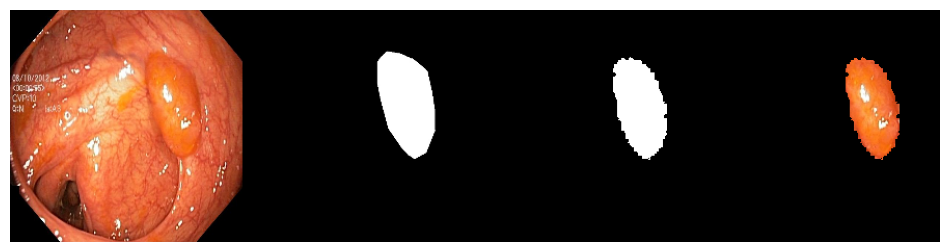

 Epoch: 15 of 100, Iter.: 75 of 75, Train Loss: 0.098337, IoU: 0.911027, Dice: 0.950381
 Epoch: 15 of 100, Iter.: 75 of 75, Valid Loss: 0.433969, IoU: 0.759573, Dice: 0.842572


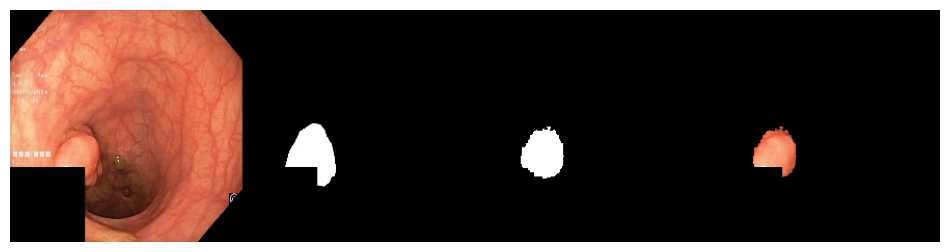

 Epoch: 16 of 100, Iter.: 75 of 75, Train Loss: 0.093512, IoU: 0.915586, Dice: 0.954015
 Epoch: 16 of 100, Iter.: 75 of 75, Valid Loss: 0.454237, IoU: 0.764415, Dice: 0.842340


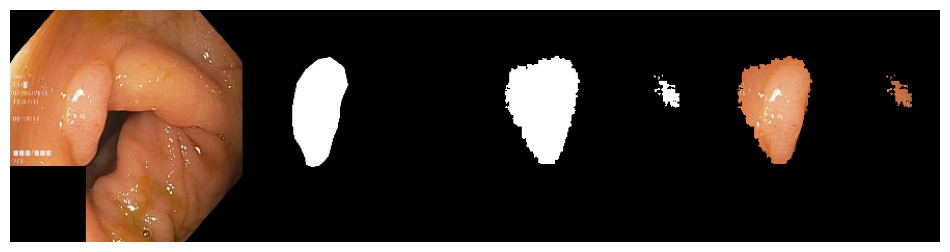

 Epoch: 17 of 100, Iter.: 75 of 75, Train Loss: 0.089776, IoU: 0.918510, Dice: 0.955572
 Epoch: 17 of 100, Iter.: 75 of 75, Valid Loss: 0.435717, IoU: 0.769238, Dice: 0.847801


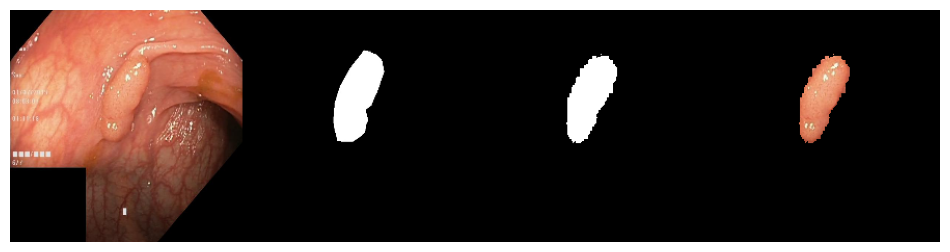

 Epoch: 18 of 100, Iter.: 75 of 75, Train Loss: 0.085330, IoU: 0.923486, Dice: 0.958488
 Epoch: 18 of 100, Iter.: 75 of 75, Valid Loss: 0.425423, IoU: 0.775714, Dice: 0.854001


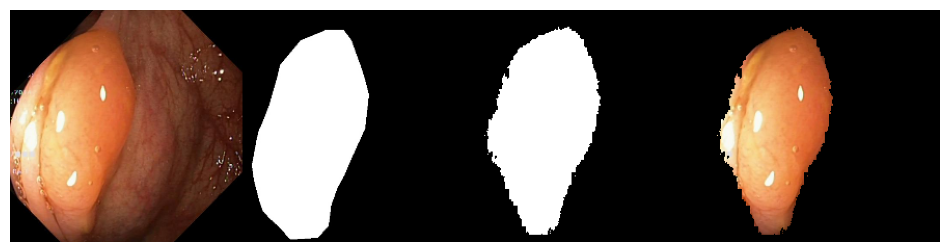

 Epoch: 19 of 100, Iter.: 75 of 75, Train Loss: 0.081521, IoU: 0.928059, Dice: 0.961206
 Epoch: 19 of 100, Iter.: 75 of 75, Valid Loss: 0.447383, IoU: 0.772648, Dice: 0.851333


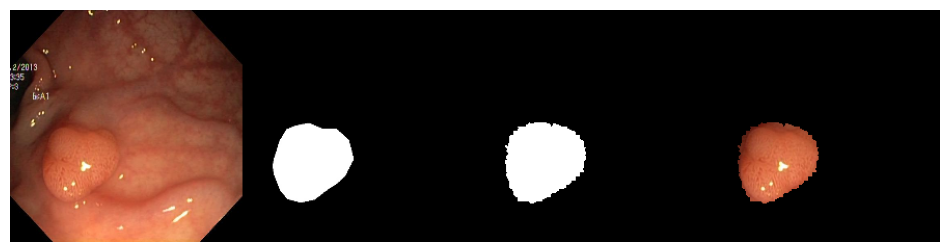

 Epoch: 20 of 100, Iter.: 75 of 75, Train Loss: 0.079006, IoU: 0.930148, Dice: 0.962891
 Epoch: 20 of 100, Iter.: 75 of 75, Valid Loss: 0.448128, IoU: 0.774653, Dice: 0.850932


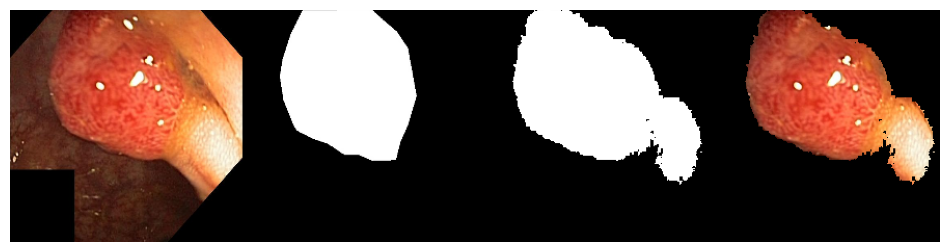

 Epoch: 21 of 100, Iter.: 75 of 75, Train Loss: 0.078039, IoU: 0.931756, Dice: 0.963936
 Epoch: 21 of 100, Iter.: 75 of 75, Valid Loss: 0.456561, IoU: 0.773031, Dice: 0.848311


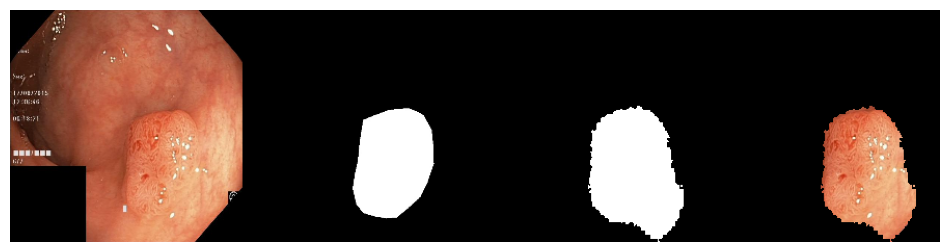

 Epoch: 22 of 100, Iter.: 75 of 75, Train Loss: 0.077478, IoU: 0.930909, Dice: 0.962714
 Epoch: 22 of 100, Iter.: 75 of 75, Valid Loss: 0.453712, IoU: 0.778719, Dice: 0.854397


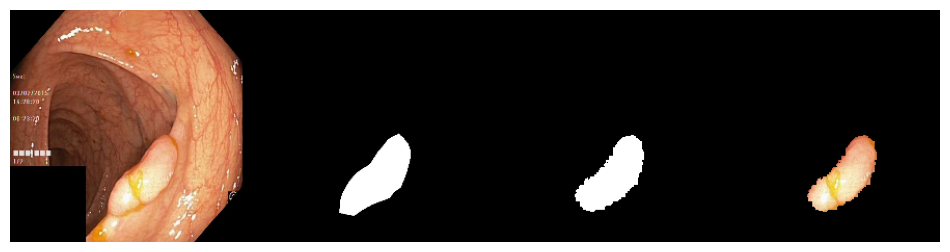

 Epoch: 23 of 100, Iter.: 75 of 75, Train Loss: 0.075851, IoU: 0.933704, Dice: 0.964996
 Epoch: 23 of 100, Iter.: 75 of 75, Valid Loss: 0.443889, IoU: 0.780303, Dice: 0.856216


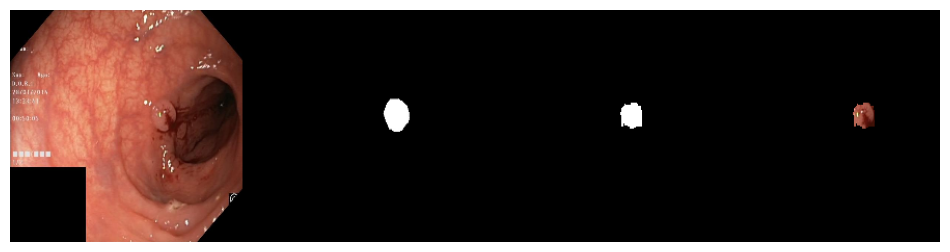

 Epoch: 24 of 100, Iter.: 75 of 75, Train Loss: 0.072196, IoU: 0.936790, Dice: 0.966064
 Epoch: 24 of 100, Iter.: 75 of 75, Valid Loss: 0.477933, IoU: 0.777316, Dice: 0.853605


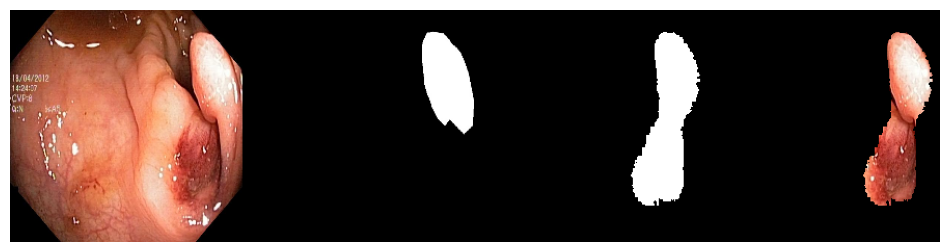

 Epoch: 25 of 100, Iter.: 75 of 75, Train Loss: 0.071907, IoU: 0.938707, Dice: 0.967880
 Epoch: 25 of 100, Iter.: 75 of 75, Valid Loss: 0.459282, IoU: 0.779420, Dice: 0.854648


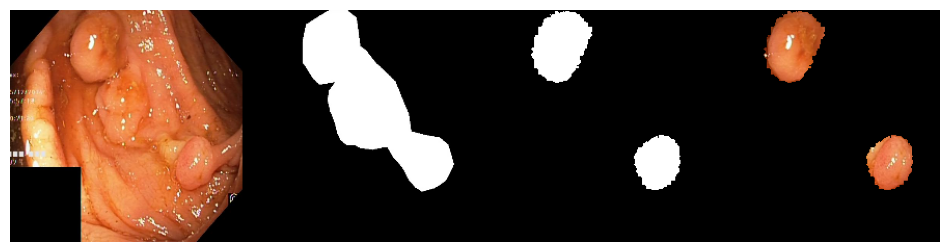

 Epoch: 26 of 100, Iter.: 75 of 75, Train Loss: 0.069487, IoU: 0.940167, Dice: 0.968378
 Epoch: 26 of 100, Iter.: 75 of 75, Valid Loss: 0.484057, IoU: 0.777768, Dice: 0.855095


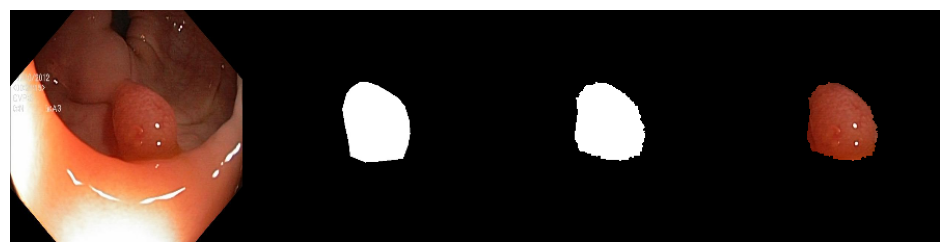

 Epoch: 27 of 100, Iter.: 75 of 75, Train Loss: 0.071998, IoU: 0.937197, Dice: 0.967031
 Epoch: 27 of 100, Iter.: 75 of 75, Valid Loss: 0.484805, IoU: 0.778645, Dice: 0.855806


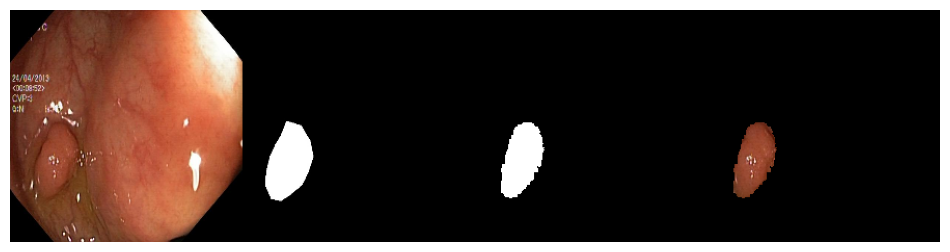

 Epoch: 28 of 100, Iter.: 75 of 75, Train Loss: 0.070982, IoU: 0.937390, Dice: 0.967183
 Epoch: 28 of 100, Iter.: 75 of 75, Valid Loss: 0.515649, IoU: 0.776102, Dice: 0.851033


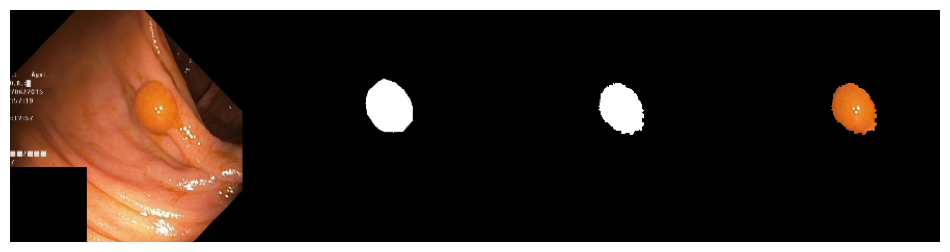

 Epoch: 29 of 100, Iter.: 75 of 75, Train Loss: 0.069535, IoU: 0.940016, Dice: 0.968653
 Epoch: 29 of 100, Iter.: 75 of 75, Valid Loss: 0.502561, IoU: 0.777110, Dice: 0.852359


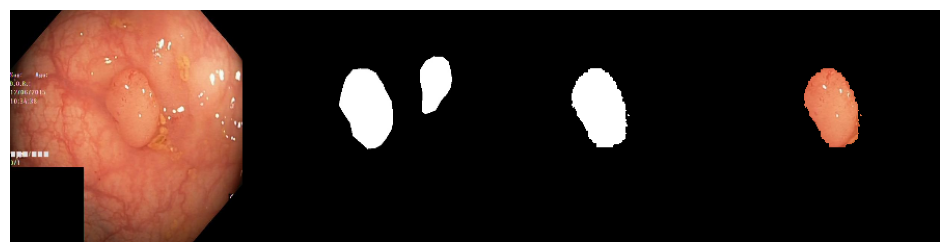

 Epoch: 30 of 100, Iter.: 75 of 75, Train Loss: 0.067300, IoU: 0.941916, Dice: 0.969569
 Epoch: 30 of 100, Iter.: 75 of 75, Valid Loss: 0.496795, IoU: 0.780632, Dice: 0.856437


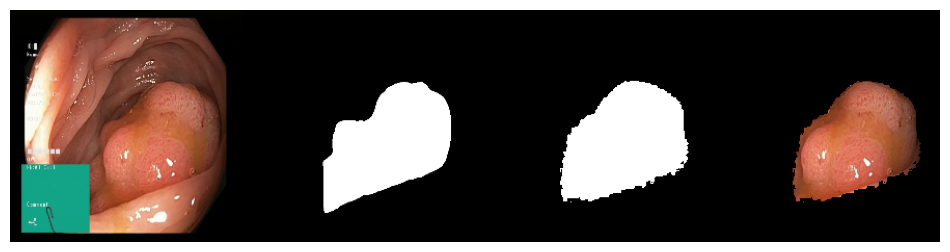

 Epoch: 31 of 100, Iter.: 75 of 75, Train Loss: 0.067596, IoU: 0.941340, Dice: 0.969221
 Epoch: 31 of 100, Iter.: 75 of 75, Valid Loss: 0.484321, IoU: 0.785308, Dice: 0.859819


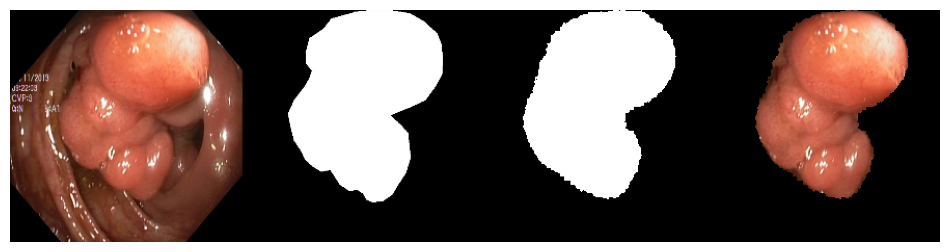

 Epoch: 32 of 100, Iter.: 75 of 75, Train Loss: 0.066197, IoU: 0.943850, Dice: 0.970715
 Epoch: 32 of 100, Iter.: 75 of 75, Valid Loss: 0.499141, IoU: 0.784163, Dice: 0.857695


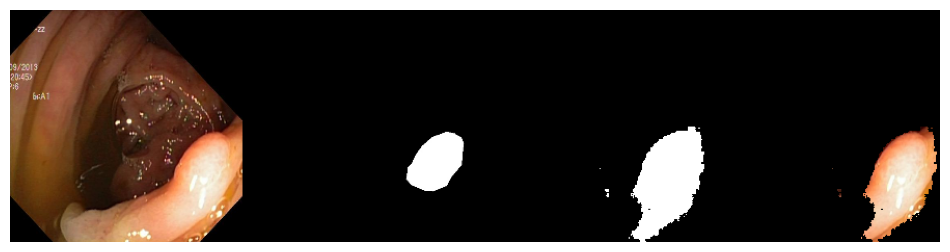

 Epoch: 33 of 100, Iter.: 75 of 75, Train Loss: 0.064317, IoU: 0.945001, Dice: 0.971304
 Epoch: 33 of 100, Iter.: 75 of 75, Valid Loss: 0.495382, IoU: 0.780590, Dice: 0.854399


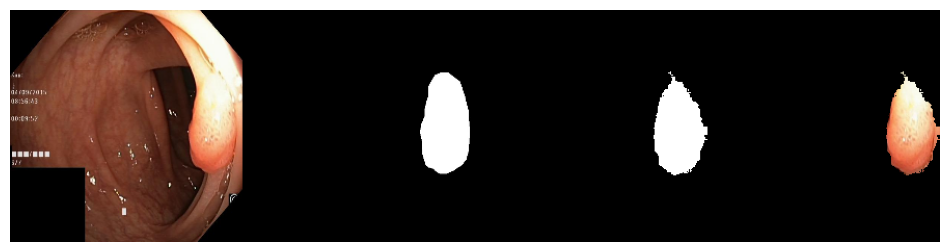

 Epoch: 34 of 100, Iter.: 75 of 75, Train Loss: 0.062010, IoU: 0.947603, Dice: 0.972791
 Epoch: 34 of 100, Iter.: 75 of 75, Valid Loss: 0.499036, IoU: 0.782628, Dice: 0.857683


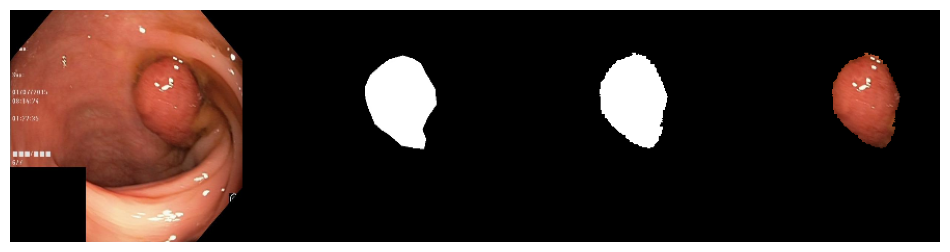

 Epoch: 35 of 100, Iter.: 75 of 75, Train Loss: 0.063545, IoU: 0.947042, Dice: 0.972466
 Epoch: 35 of 100, Iter.: 75 of 75, Valid Loss: 0.534032, IoU: 0.777258, Dice: 0.851967


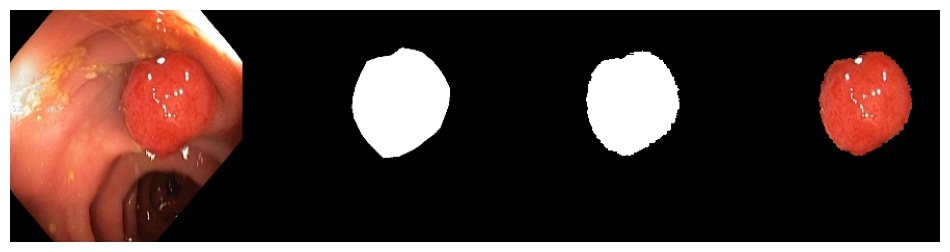

 Epoch: 36 of 100, Iter.: 75 of 75, Train Loss: 0.065629, IoU: 0.944521, Dice: 0.971133
 Epoch: 36 of 100, Iter.: 75 of 75, Valid Loss: 0.533121, IoU: 0.777787, Dice: 0.850869


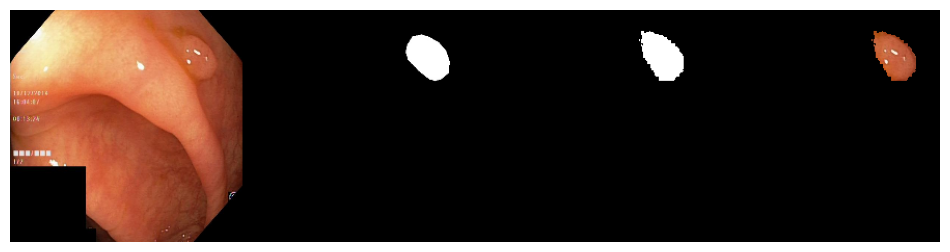

 Epoch: 37 of 100, Iter.: 75 of 75, Train Loss: 0.063397, IoU: 0.947332, Dice: 0.972676
 Epoch: 37 of 100, Iter.: 75 of 75, Valid Loss: 0.511674, IoU: 0.779729, Dice: 0.854263


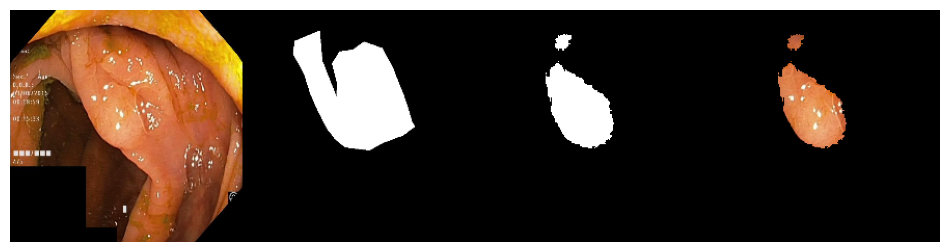

 Epoch: 38 of 100, Iter.: 75 of 75, Train Loss: 0.062083, IoU: 0.947914, Dice: 0.972913
 Epoch: 38 of 100, Iter.: 75 of 75, Valid Loss: 0.516655, IoU: 0.784610, Dice: 0.857283


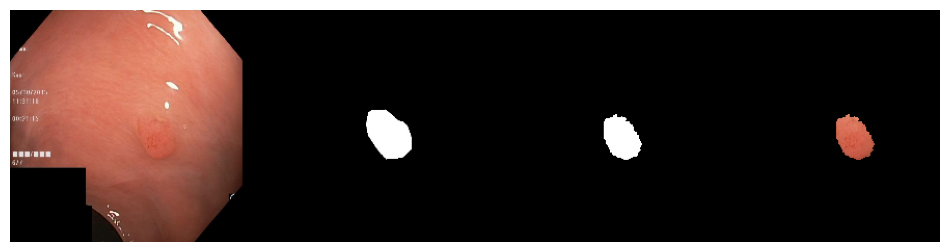

 Epoch: 39 of 100, Iter.: 75 of 75, Train Loss: 0.059532, IoU: 0.950445, Dice: 0.974371
 Epoch: 39 of 100, Iter.: 75 of 75, Valid Loss: 0.513426, IoU: 0.782878, Dice: 0.857741


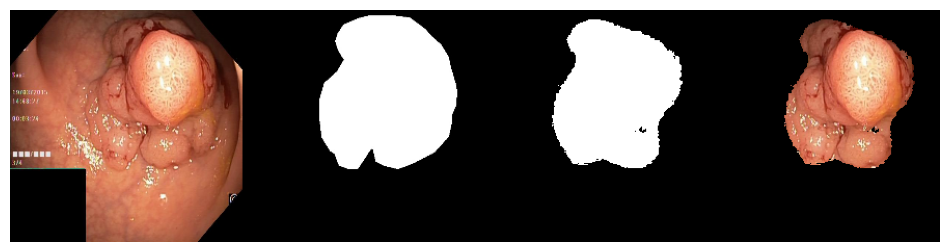

 Epoch: 40 of 100, Iter.: 75 of 75, Train Loss: 0.060289, IoU: 0.950276, Dice: 0.974245
 Epoch: 40 of 100, Iter.: 75 of 75, Valid Loss: 0.535938, IoU: 0.785455, Dice: 0.858592


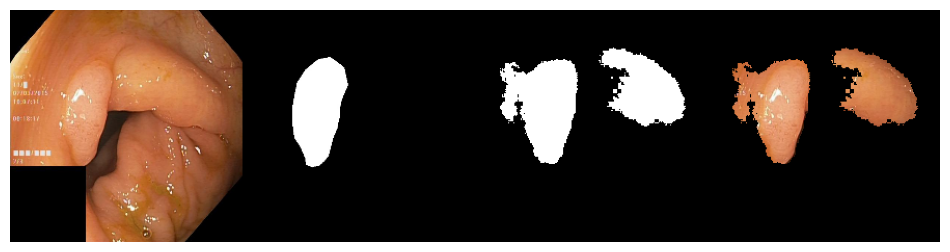

 Epoch: 41 of 100, Iter.: 75 of 75, Train Loss: 0.058602, IoU: 0.952381, Dice: 0.975414
 Epoch: 41 of 100, Iter.: 75 of 75, Valid Loss: 0.527367, IoU: 0.784493, Dice: 0.856640


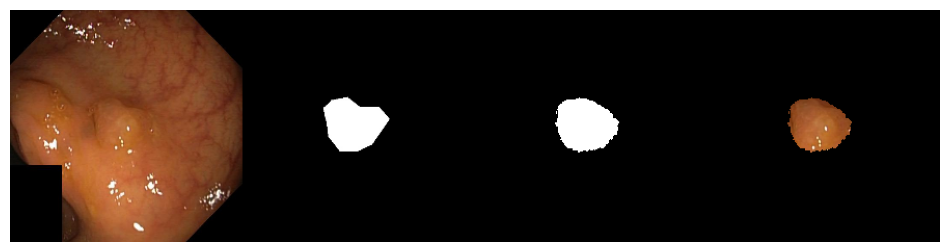

 Epoch: 42 of 100, Iter.: 75 of 75, Train Loss: 0.057612, IoU: 0.952775, Dice: 0.975629
 Epoch: 42 of 100, Iter.: 75 of 75, Valid Loss: 0.508118, IoU: 0.787468, Dice: 0.861305


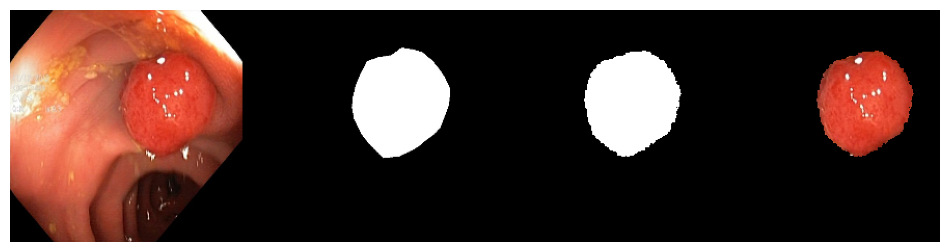

 Epoch: 43 of 100, Iter.: 75 of 75, Train Loss: 0.057186, IoU: 0.953777, Dice: 0.976165
 Epoch: 43 of 100, Iter.: 75 of 75, Valid Loss: 0.533517, IoU: 0.785060, Dice: 0.858654


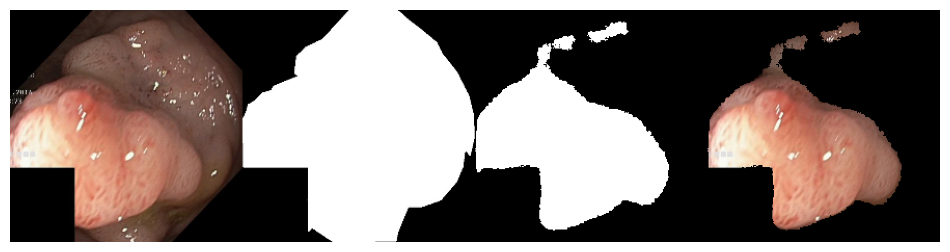

 Epoch: 44 of 100, Iter.: 75 of 75, Train Loss: 0.056580, IoU: 0.953813, Dice: 0.976146
 Epoch: 44 of 100, Iter.: 75 of 75, Valid Loss: 0.534349, IoU: 0.784446, Dice: 0.858886


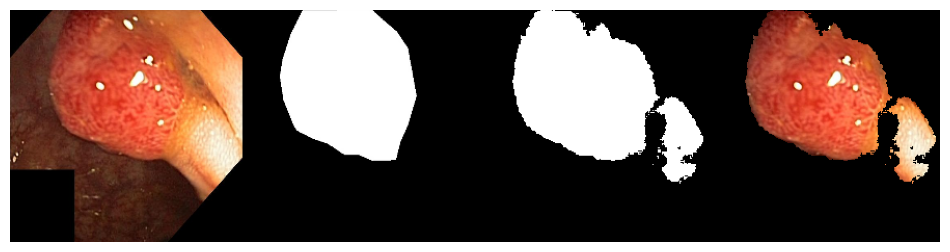

 Epoch: 45 of 100, Iter.: 75 of 75, Train Loss: 0.057049, IoU: 0.953756, Dice: 0.976140
 Epoch: 45 of 100, Iter.: 75 of 75, Valid Loss: 0.536173, IoU: 0.781381, Dice: 0.856750


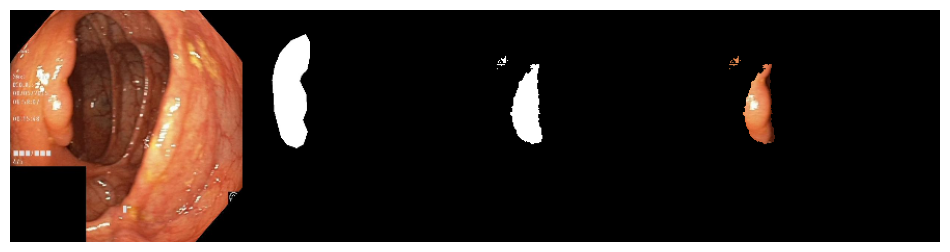

 Epoch: 46 of 100, Iter.: 75 of 75, Train Loss: 0.057104, IoU: 0.952950, Dice: 0.975643
 Epoch: 46 of 100, Iter.: 75 of 75, Valid Loss: 0.524095, IoU: 0.787709, Dice: 0.861196


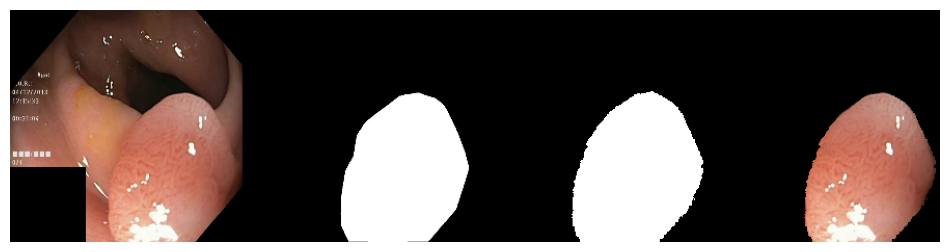

 Epoch: 47 of 100, Iter.: 75 of 75, Train Loss: 0.057842, IoU: 0.953415, Dice: 0.975958
 Epoch: 47 of 100, Iter.: 75 of 75, Valid Loss: 0.528278, IoU: 0.779219, Dice: 0.853098


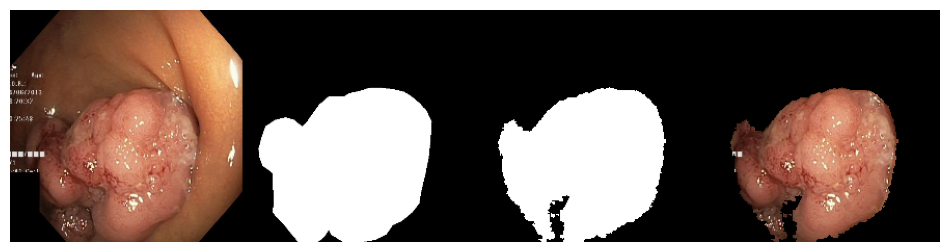

 Epoch: 48 of 100, Iter.: 75 of 75, Train Loss: 0.057747, IoU: 0.952222, Dice: 0.975303
 Epoch: 48 of 100, Iter.: 75 of 75, Valid Loss: 0.543537, IoU: 0.787627, Dice: 0.859526


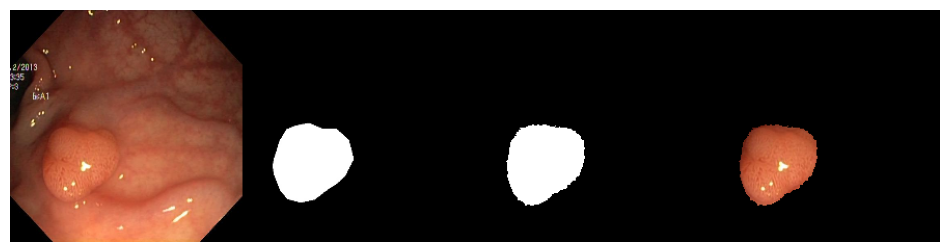

 Epoch: 49 of 100, Iter.: 75 of 75, Train Loss: 0.116041, IoU: 0.916519, Dice: 0.950828
 Epoch: 49 of 100, Iter.: 75 of 75, Valid Loss: 0.793342, IoU: 0.582818, Dice: 0.691379


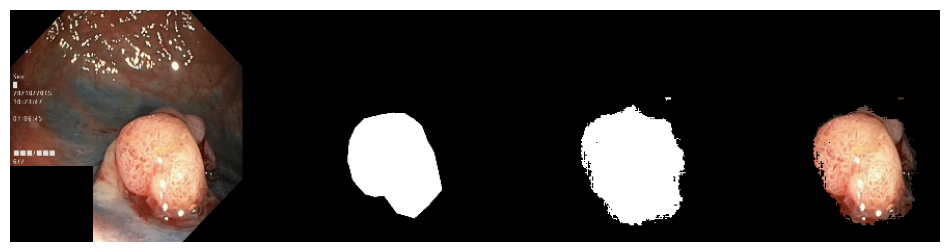

 Epoch: 50 of 100, Iter.: 75 of 75, Train Loss: 0.369795, IoU: 0.724417, Dice: 0.818063
 Epoch: 50 of 100, Iter.: 75 of 75, Valid Loss: 0.445901, IoU: 0.704417, Dice: 0.798347


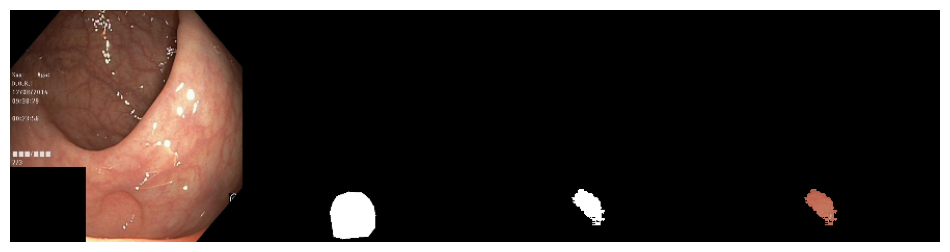

 Epoch: 51 of 100, Iter.: 75 of 75, Train Loss: 0.212935, IoU: 0.821404, Dice: 0.889596
 Epoch: 51 of 100, Iter.: 75 of 75, Valid Loss: 0.463678, IoU: 0.708675, Dice: 0.797768


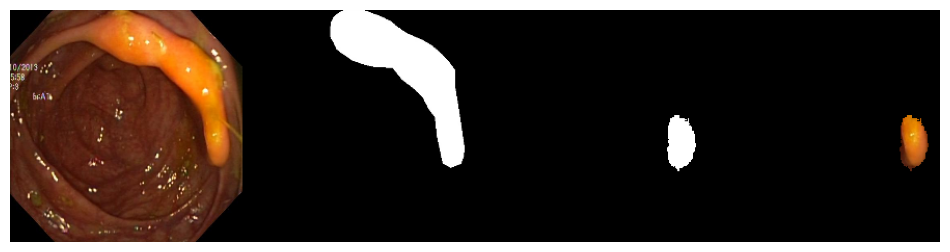

 Epoch: 52 of 100, Iter.: 75 of 75, Train Loss: 0.174409, IoU: 0.851959, Dice: 0.909973
 Epoch: 52 of 100, Iter.: 75 of 75, Valid Loss: 0.473716, IoU: 0.715855, Dice: 0.797821


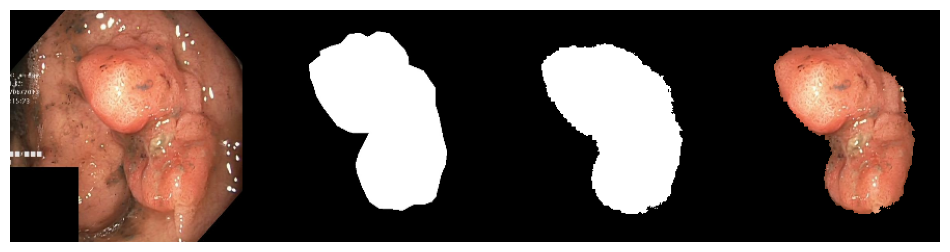

 Epoch: 53 of 100, Iter.: 75 of 75, Train Loss: 0.114708, IoU: 0.895682, Dice: 0.939840
 Epoch: 53 of 100, Iter.: 75 of 75, Valid Loss: 0.410898, IoU: 0.745313, Dice: 0.822683


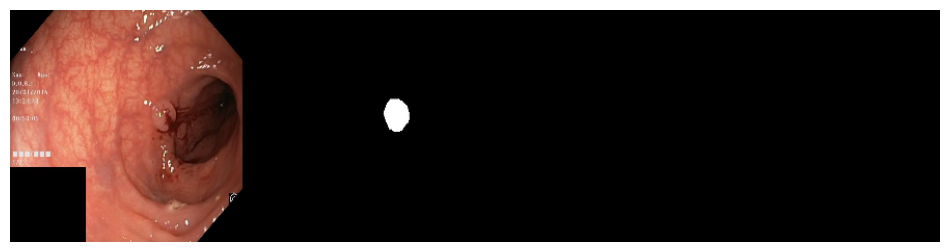

 Epoch: 54 of 100, Iter.: 75 of 75, Train Loss: 0.096580, IoU: 0.909770, Dice: 0.948901
 Epoch: 54 of 100, Iter.: 75 of 75, Valid Loss: 0.475110, IoU: 0.746237, Dice: 0.826047


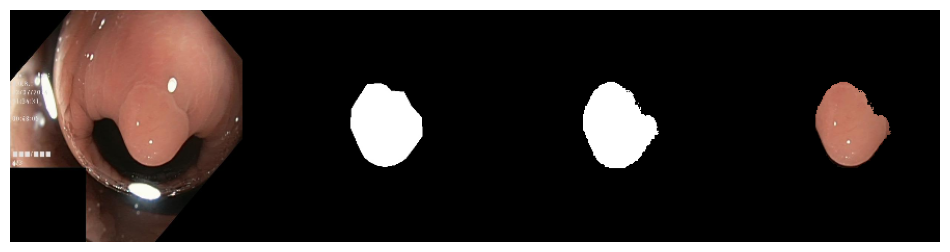

 Epoch: 55 of 100, Iter.: 75 of 75, Train Loss: 0.080981, IoU: 0.926467, Dice: 0.959164
 Epoch: 55 of 100, Iter.: 75 of 75, Valid Loss: 0.426731, IoU: 0.765522, Dice: 0.844511


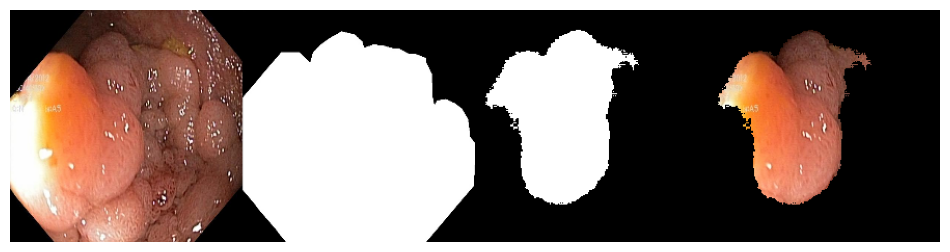

 Epoch: 56 of 100, Iter.: 75 of 75, Train Loss: 0.067177, IoU: 0.941643, Dice: 0.969409
 Epoch: 56 of 100, Iter.: 75 of 75, Valid Loss: 0.435827, IoU: 0.765493, Dice: 0.844275


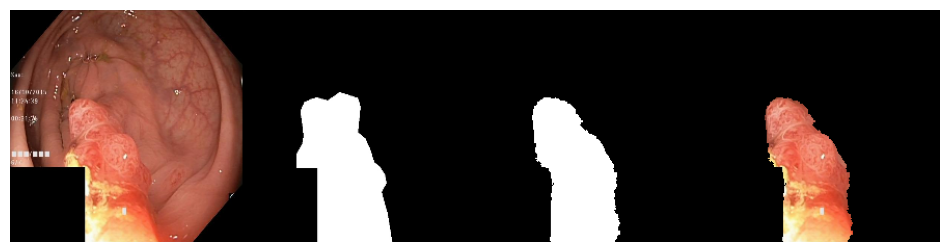

 Epoch: 57 of 100, Iter.: 75 of 75, Train Loss: 0.063556, IoU: 0.945220, Dice: 0.971246
 Epoch: 57 of 100, Iter.: 75 of 75, Valid Loss: 0.468501, IoU: 0.764839, Dice: 0.844089


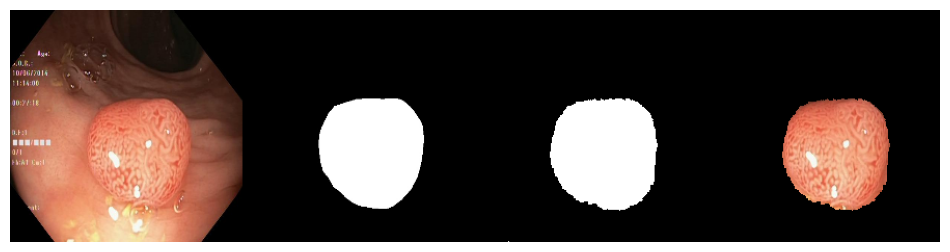

 Epoch: 58 of 100, Iter.: 75 of 75, Train Loss: 0.060070, IoU: 0.948811, Dice: 0.973391
 Epoch: 58 of 100, Iter.: 75 of 75, Valid Loss: 0.445982, IoU: 0.773484, Dice: 0.851056


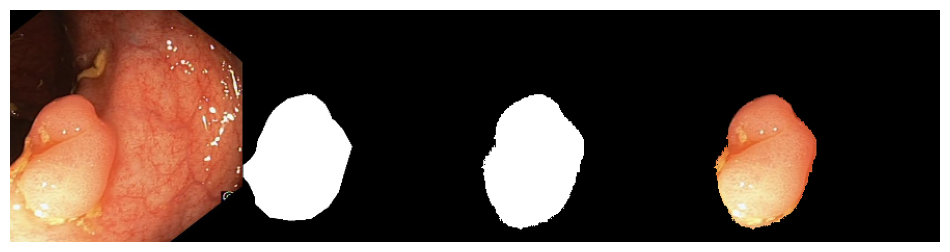

 Epoch: 59 of 100, Iter.: 75 of 75, Train Loss: 0.057293, IoU: 0.952087, Dice: 0.975097
 Epoch: 59 of 100, Iter.: 75 of 75, Valid Loss: 0.469923, IoU: 0.771266, Dice: 0.849513


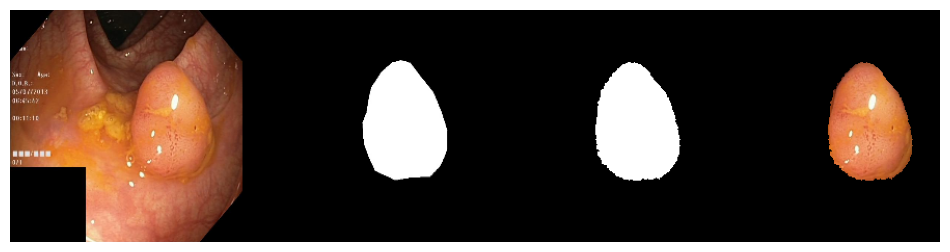

 Epoch: 60 of 100, Iter.: 75 of 75, Train Loss: 0.054631, IoU: 0.955324, Dice: 0.976940
 Epoch: 60 of 100, Iter.: 75 of 75, Valid Loss: 0.475924, IoU: 0.772559, Dice: 0.851206


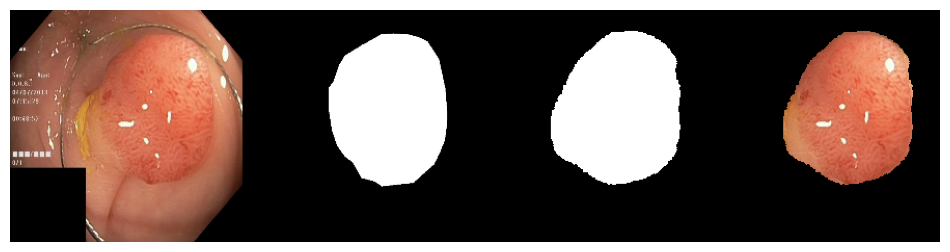

 Epoch: 61 of 100, Iter.: 75 of 75, Train Loss: 0.053731, IoU: 0.955836, Dice: 0.977186
 Epoch: 61 of 100, Iter.: 75 of 75, Valid Loss: 0.471959, IoU: 0.771531, Dice: 0.850846


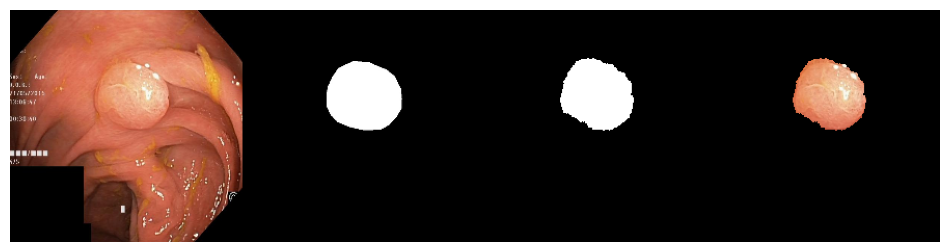

 Epoch: 62 of 100, Iter.: 75 of 75, Train Loss: 0.053151, IoU: 0.956374, Dice: 0.977486
 Epoch: 62 of 100, Iter.: 75 of 75, Valid Loss: 0.527955, IoU: 0.765297, Dice: 0.841487


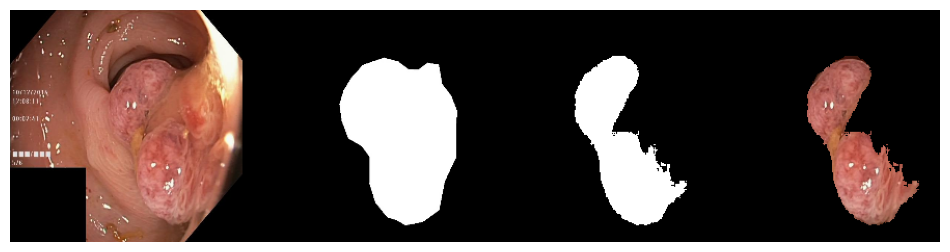

 Epoch: 63 of 100, Iter.: 75 of 75, Train Loss: 0.051942, IoU: 0.957926, Dice: 0.978264
 Epoch: 63 of 100, Iter.: 75 of 75, Valid Loss: 0.532522, IoU: 0.766218, Dice: 0.843050


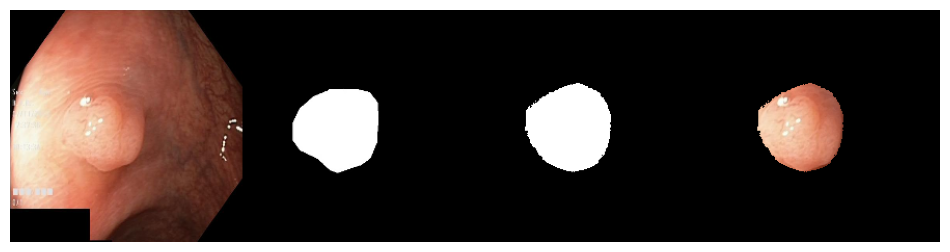


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 17min 43s, sys: 7min 34s, total: 25min 17s
Wall time: 20min


In [11]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:42, Best_IOU:0.7877, Best_DiceScore:0.8613


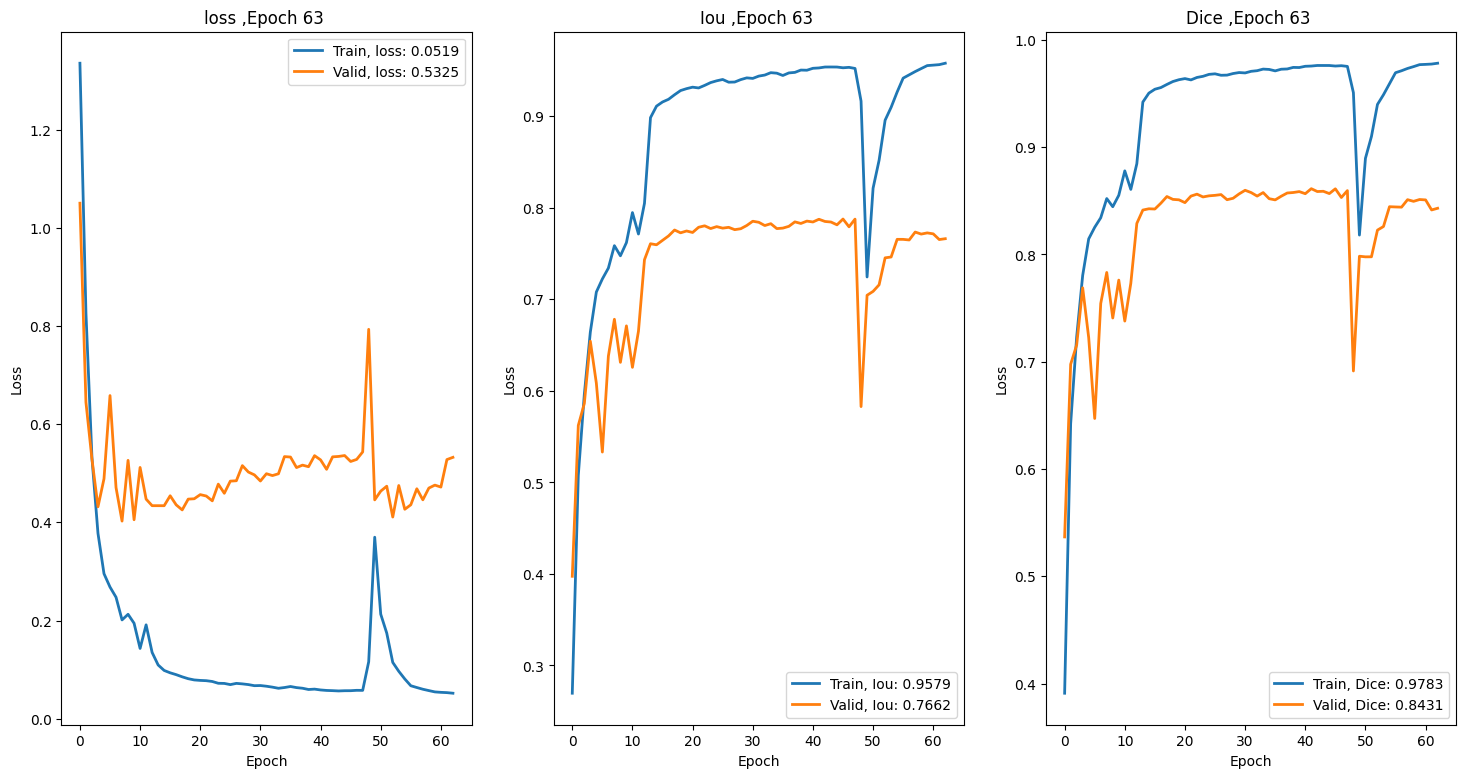

In [13]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()